In [16]:
import os
import shutil
import glob
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

from utils import *
from plot_utils import *
from AnalyseDefects_dev import AnalyseDefects

import massPy as mp

In [40]:
def sort_files(files, key = lambda x: int(x.split('frame')[-1].split('.')[0])):
    return sorted(files, key=key)

def calc_distance_matrix(points, L=None, periodic=False):
    """
    Calculate the distance matrix between points in an N-dimensional space.

    Parameters:
    -----------
    points : np.ndarray
        Array of points in N-dimensional space. Shape (N, D) where N is the number of points and D is the dimensionality.
    L : float
        Length of the square domain in each dimension. If periodic is True, this is required.
    periodic : bool
        If True, use periodic boundary conditions.

    Returns:
    --------
    distance_matrix : np.ndarray
        Array of distances between points. Shape (N, N).
    """ 

    displacement = points[:, None] - points[None, :]
    if periodic:
        min_func_vectorized = lambda x: np.minimum(x, L - x)
        dr = np.apply_along_axis(min_func_vectorized, axis = -1, arr = np.abs(displacement))
    else:
        dr = displacement
    return np.sqrt(np.sum(dr**2, axis=-1))

def calc_mean_nearest_neighbor_dist(distance_matrix,):
    """
    Calculate the mean nearest neighbor distance for each point in a set of points.

    Parameters:
    -----------
    distance_matrix : np.ndarray
        Array of distances between points. Shape (N, N).
    
    Returns:
    --------
    mean_nearest_neighbour_dist : float
        Mean nearest neighbor distance.
    std_nearest_neighbour_dist : float
        Standard deviation of the mean nearest neighbor distance.
    """

    dist  = distance_matrix.astype('float64')
    np.fill_diagonal(dist, np.inf)
    nearest_neighbours_all = np.min(dist, axis = 1)
    return np.mean(nearest_neighbours_all), np.std(nearest_neighbours_all) / np.sqrt(len(nearest_neighbours_all))

def get_clustering_signed(top_defect_list, method, L, rmax_list, method_kwargs, periodic = False, \
                          save = False, save_dir = None):
    """
    
    Parameters:
    -----------
    Returns:
    --------
    """
  
    Nframes = len(top_defect_list)
    Nwindows = len(rmax_list)

    cl_arr = np.nan * np.ones([Nframes, Nwindows, 3])
    nearest_neighbours_arr = np.nan * np.ones([Nframes, 2])
   
    for frame, defects in enumerate(top_defect_list):
        # Get defect array for frame
        defect_arr = get_defect_arr_from_frame(defects, return_charge = True)

        if defect_arr is None:
            continue

        defect_positions = defect_arr[:, :-1]
        defect_charges = defect_arr[:, -1] 

        distance_matrix = calc_distance_matrix(defect_positions, L = L, periodic = periodic)
        nearest_neighbours_arr[frame] = calc_mean_nearest_neighbor_dist(distance_matrix)

        for i, rmax in enumerate(rmax_list):
            cst = method(distance_threshold = rmax, **method_kwargs, metric='precomputed')
            labels = cst.fit_predict(distance_matrix)

            Ncl = np.max(labels) + 1
            Qc_arr = np.zeros(Ncl)

            for N in range(Ncl):
                mask = (labels == N)
                Qc = np.sum(defect_charges[mask])
                Qc_arr[N] = Qc
 
            all_neutral = float(np.all(Qc_arr == 0))
            Qcl = np.sum(np.abs(Qc_arr)) / Ncl
            cl_arr[frame, i] = [Ncl, Qcl, all_neutral]

            if Ncl == 1:
                break

    if save:
        # save labels list
        np.save(os.path.join(save_dir, 'cl_arr.npy') if save_dir is not None else 'cl_arr.npy', cl_arr)
        np.save(os.path.join(save_dir, 'nn_arr.npy') if save_dir is not None else 'nn_arr.npy', nearest_neighbours_arr)
    return cl_arr, nearest_neighbours_arr

In [89]:
path = "Z:/ns_param_exploration/ns512lfric10bc3/output_test_zeta_0.019/output_test_zeta_0.019_counter_0/"
def_path = "Z:/nematic_analysis/na512exploration/na512lfric10bc3/defect_positions/analysis_zeta_0.019/zeta_0.019_counter_1/defect_positions.pkl"
#def_path = "Z:/nematic_analysis/na512exploration/na512lfric10bc4/defect_positions/analysis_zeta_0.022/zeta_0.022_counter_1/defect_positions.pkl"

# load defect dictionary
with open(def_path, 'rb') as f:
    def_dict = pkl.load(f)

# sort files in directory
#files_sorted = sort_files(glob.glob(os.path.join(path, 'frame*')))
def_path

'Z:/nematic_analysis/na512exploration/na512lfric10bc3/defect_positions/analysis_zeta_0.019/zeta_0.019_counter_1/defect_positions.pkl'

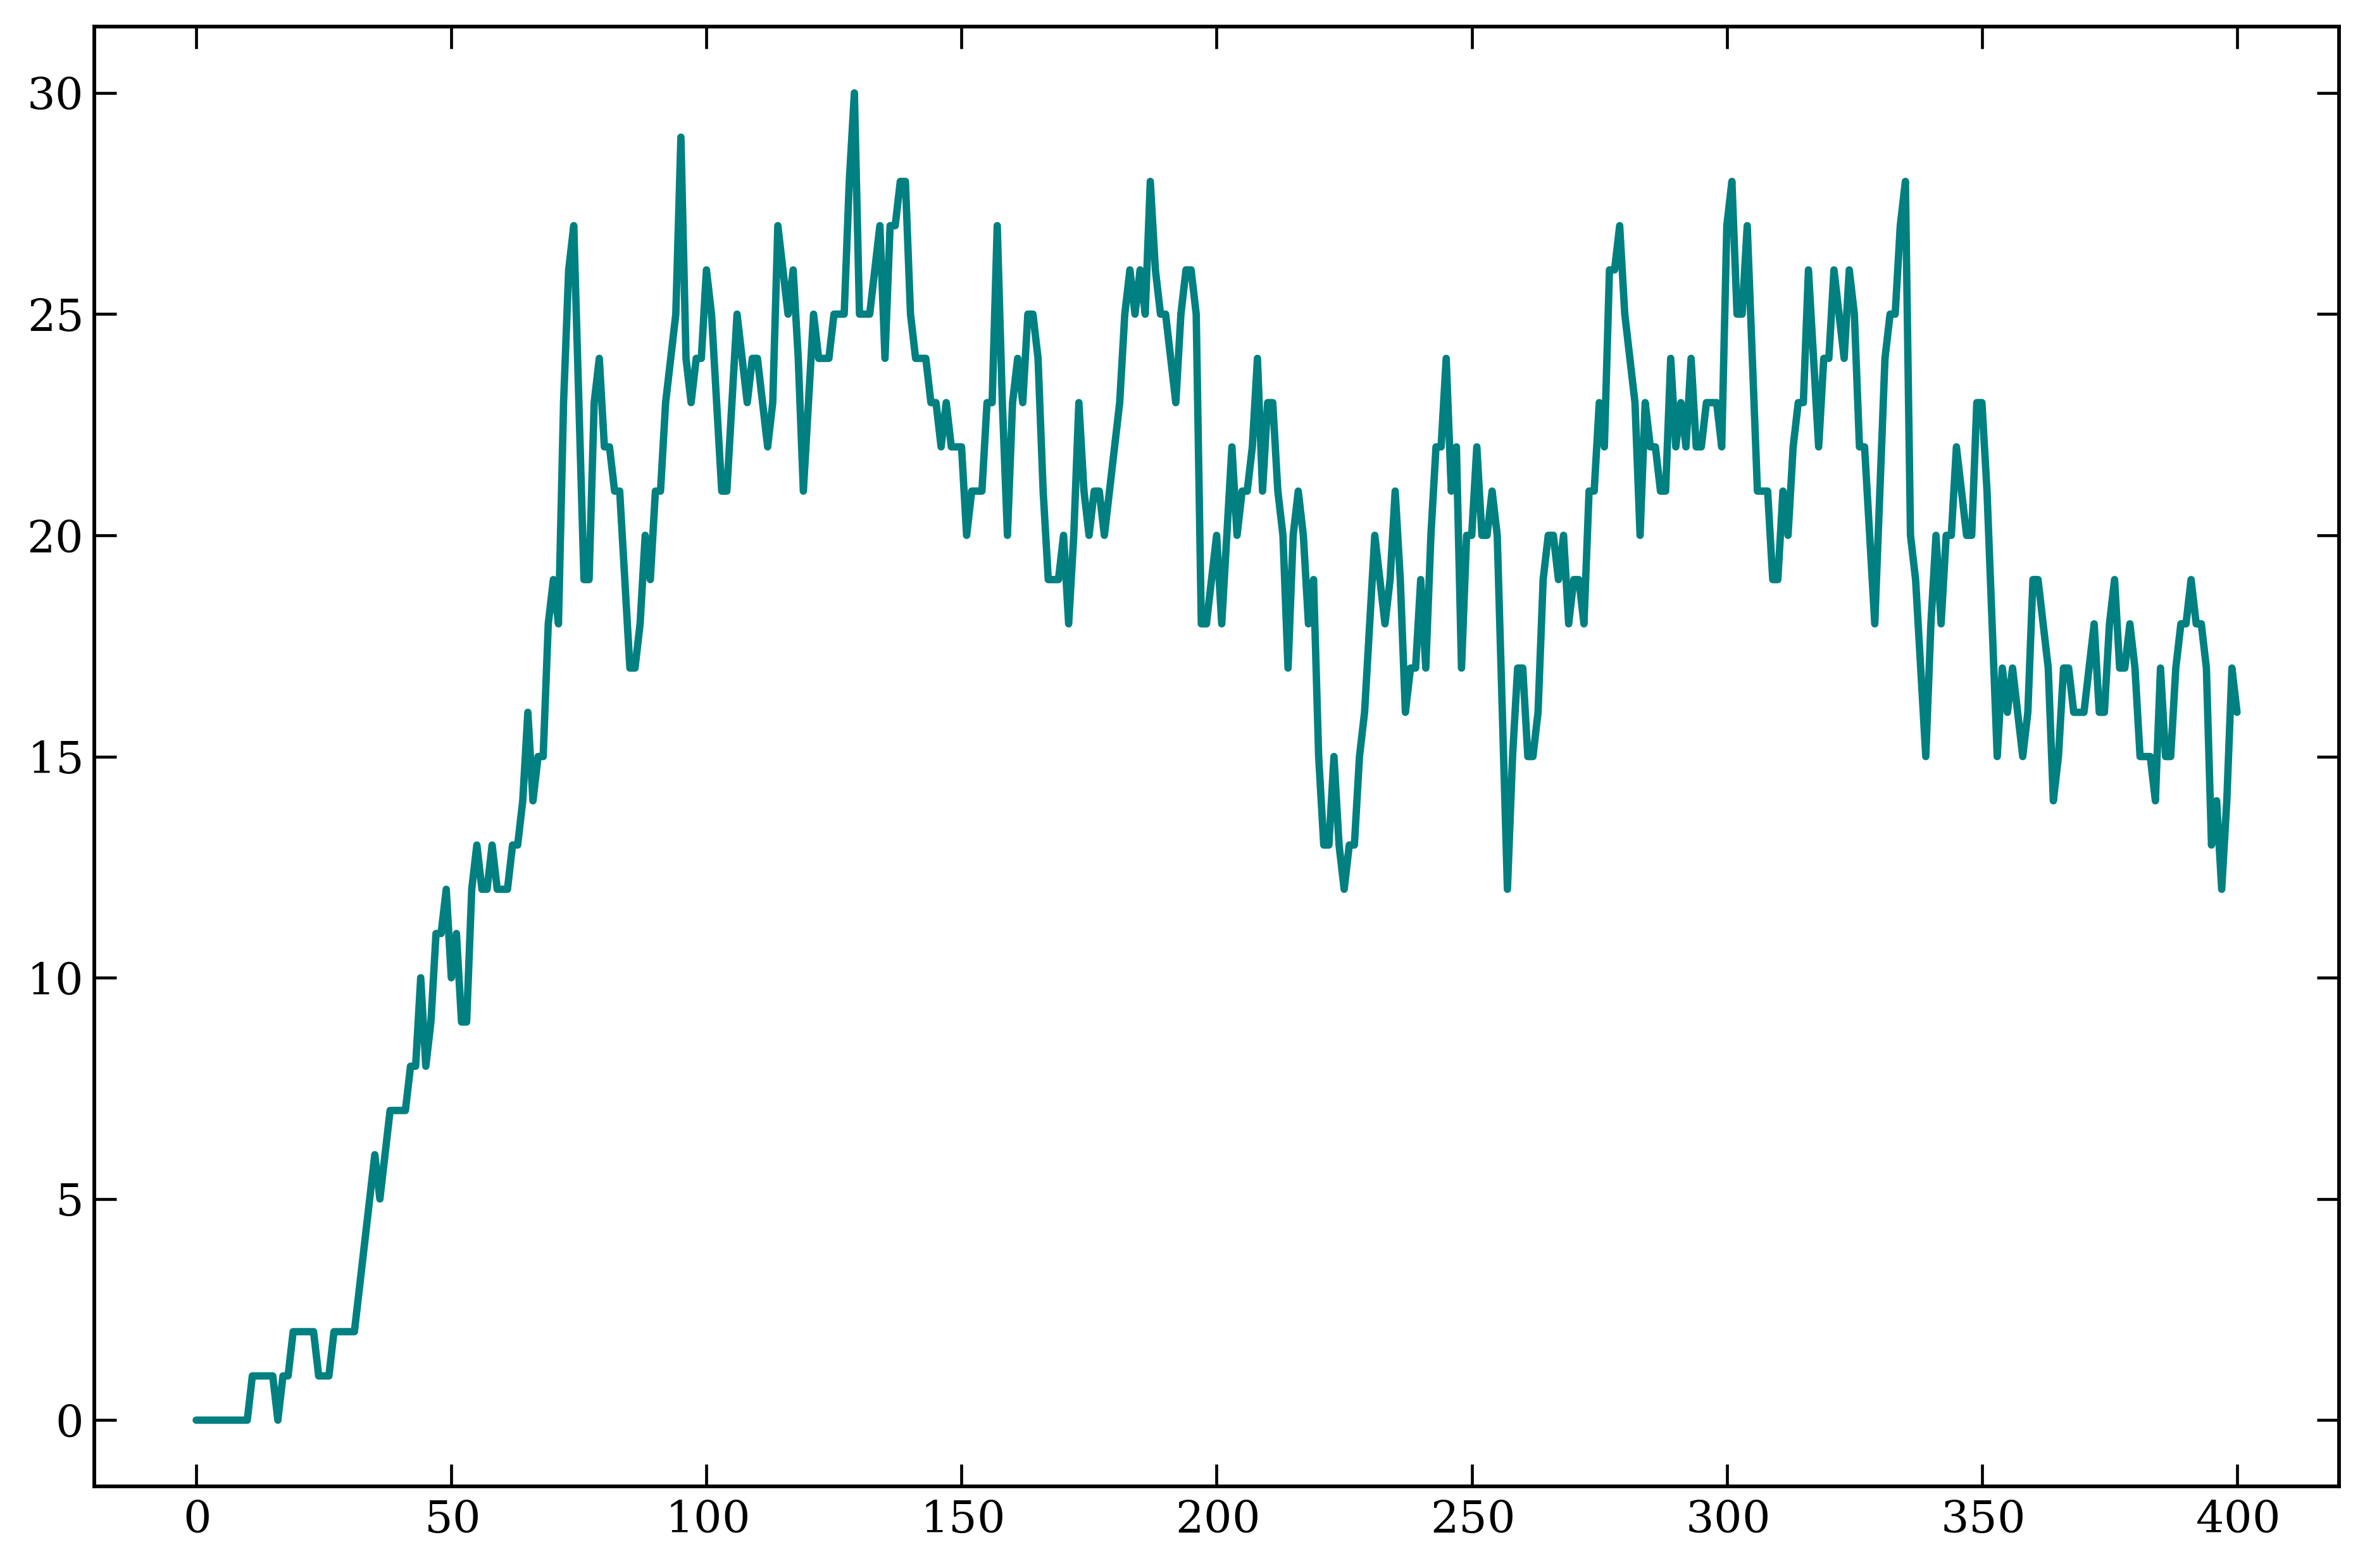

In [91]:
Lbound = 25
def_arr_list = []
def_charge_arr = np.zeros(len(def_dict))
num_def_arr = np.zeros(len(def_dict))
for f in range(len(def_dict)):
    def_arr = get_defect_arr_from_frame(def_dict[f], return_charge=True)
    if def_arr is None:
        continue

    mask_lower = (def_arr[:,0] > Lbound) & (def_arr[:,1] > Lbound)
    mask_upper = (def_arr[:,0] < 512 - Lbound) & (def_arr[:,1] < 512 - Lbound)
    mask = mask_lower & mask_upper
    def_arr = def_arr[mask]
    def_arr_list.append(def_arr)
    def_charge_arr[f] = def_arr[:,-1].sum()
    num_def_arr[f] = def_arr.shape[0]
fidx_conv = 100
plt.plot(num_def_arr)

In [92]:

periodic=False
L = 512
Nframes = len(def_dict) - fidx_conv
nearest_neighbours_arr = np.nan * np.ones([Nframes, 2])
   
for frame, defect_arr in enumerate(def_arr_list[fidx_conv:]):
    # Get defect array for frame
   # defect_arr = get_defect_arr_from_frame(defects, return_charge = True)

    if defect_arr is None:
        continue

    defect_positions = defect_arr[:, :-1]
    defect_charges = defect_arr[:, -1] 

    distance_matrix = calc_distance_matrix(defect_positions, L = L, periodic = periodic)
    nearest_neighbours_arr[frame] = calc_mean_nearest_neighbor_dist(distance_matrix)


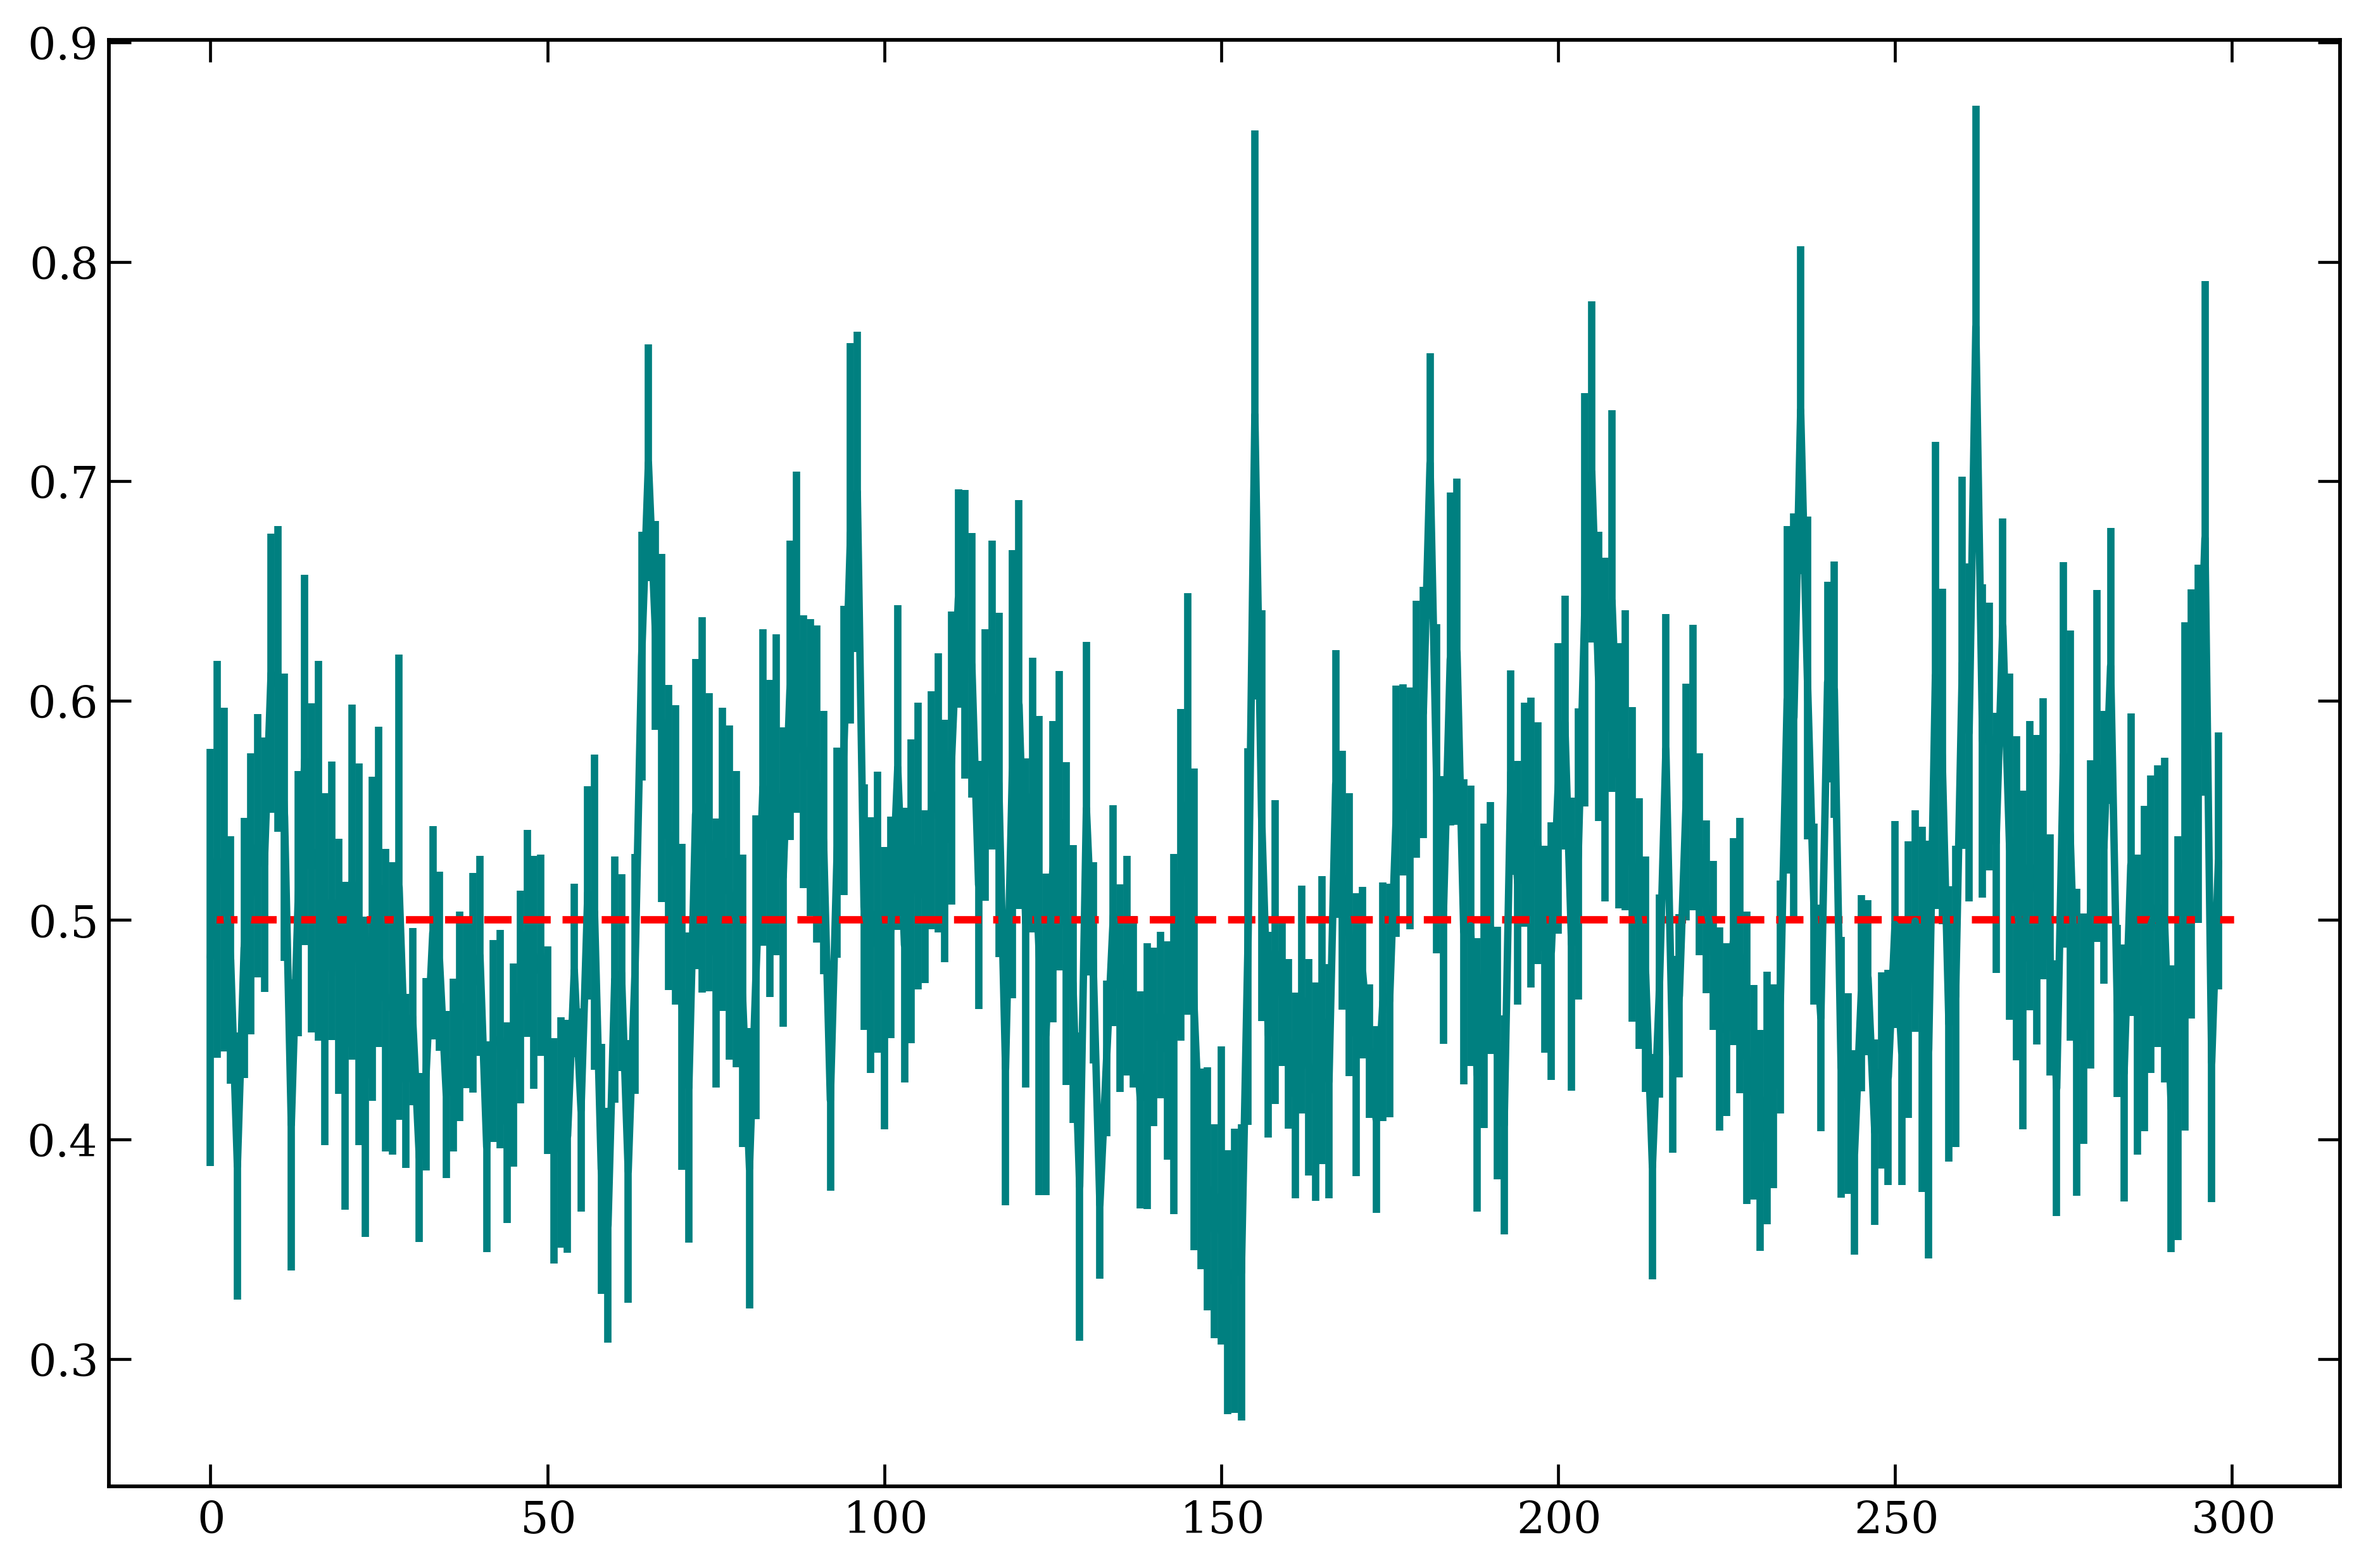

In [93]:
av_dist_arr =  L / np.sqrt(num_def_arr[fidx_conv:])
plt.errorbar(np.arange(Nframes), nearest_neighbours_arr[:,0] / av_dist_arr, nearest_neighbours_arr[:,1]/ av_dist_arr)
plt.hlines(0.5, 0, Nframes, colors='r', linestyles='dashed')
#plt.ylim(0, 1)

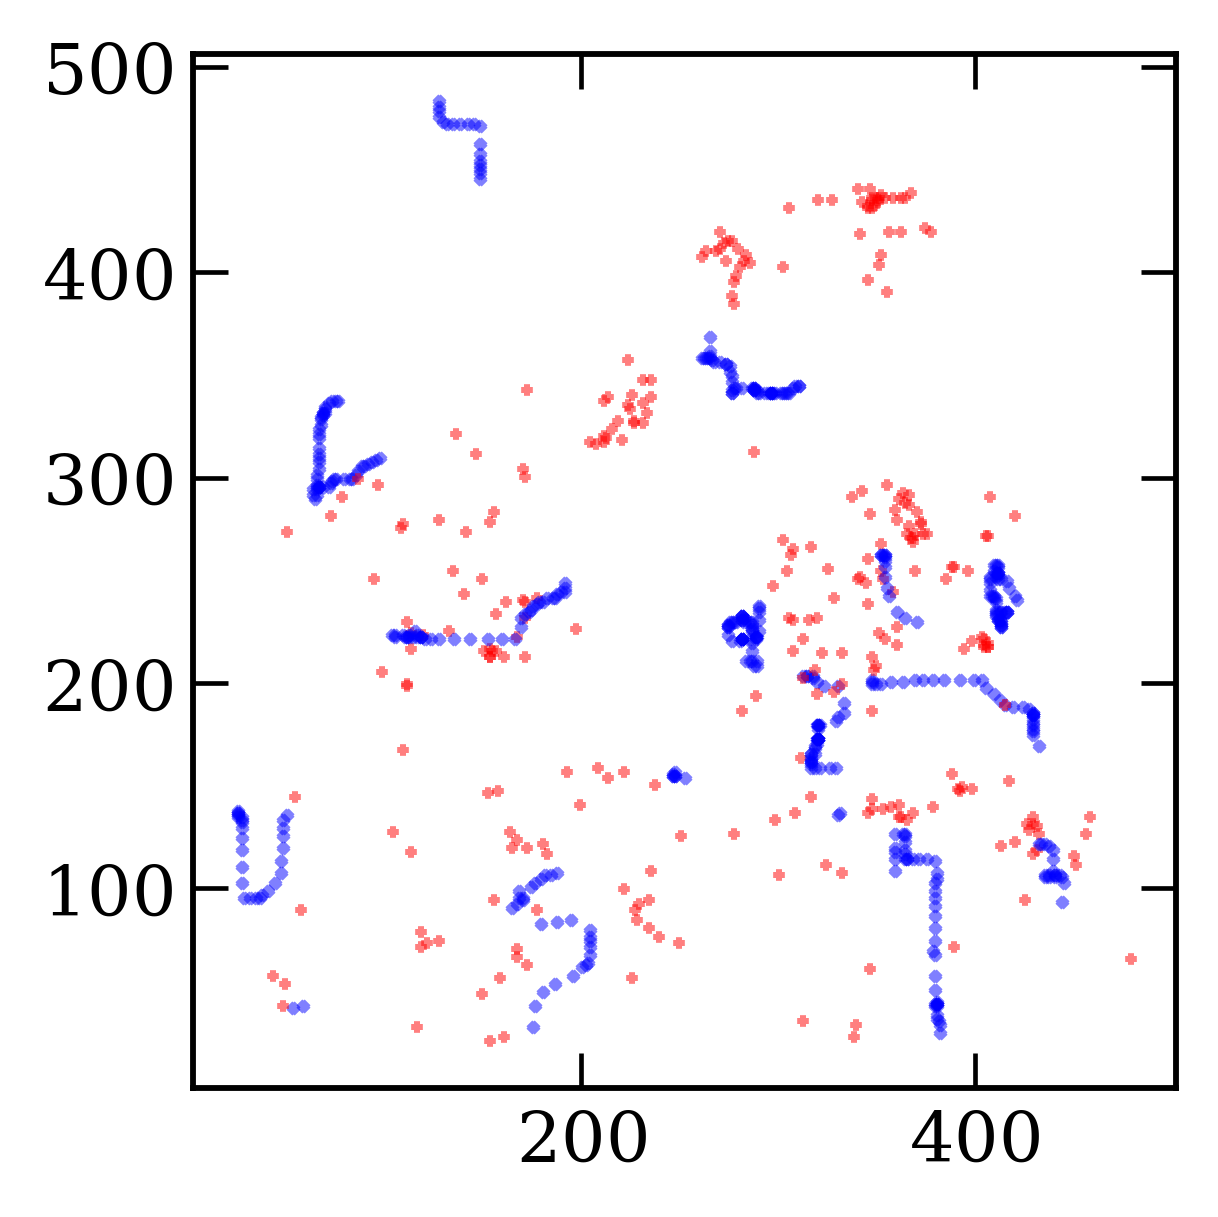

In [86]:
nf=50
fig, ax = plt.subplots(figsize=(3,3))
for k, def_arr in enumerate(def_arr_list[-nf:]):
   # def_arr=get_defect_arr_from_frame(defects, return_charge = True) #True)
    plus_mask = def_arr[:,2] > 0

    ax.scatter(def_arr[plus_mask,0], def_arr[plus_mask,1], alpha=.5,s=1,
            label=f'Frame {k}', marker='+', color='red')
    ax.scatter(def_arr[~plus_mask,0], def_arr[~plus_mask,1], alpha=.5,s=1,
                label=f'Frame {k}', marker='x', color='blue')
    #ax.set_title(rf'$T^*$ = {T}')

In [ ]:
Nframes=50
act_idx_min=0

for i, lambda_val in enumerate([0, .1, .5, 1]):

    out_path_main = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\{mode}\\na{LX}\\{lambda_val}'
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))

    fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(10,10))
    ax = ax.flatten()

    #adder = 1 if lambda_val == 0.5 else 0
    adder=0
    fig.suptitle(rf'$\lambda$ = {lambda_val}',y=0.94)

    for j, T in enumerate(act_bck[act_idx_min + adder:act_idx_min + 4 + adder]):
     
        suffi='2' if lambda_val == 1 else ''
        path_bck = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\jayeeta\\diff_lambda2\\wet\\na256\\{lambda_val}\\bck\\wet-ps-{T}-out{suffi}\\defect_positions.pkl'

        defect_dict = pickle.load(open(path_bck, 'rb'))
        ax[j].set_aspect('equal')
        ax[j].set_xlim([0, 256])
        ax[j].set_ylim([0, 256])
        ax[j].xaxis.set_ticks_position('none') 
        ax[j].yaxis.set_ticks_position('none')
   

        for k, defects in enumerate(defect_dict[-Nframes:]):
            def_arr=get_defect_arr_from_frame(defects, return_charge = True) #True)
            plus_mask = def_arr[:,2] > 0

            ax[j].scatter(def_arr[plus_mask,0], def_arr[plus_mask,1], alpha=.5,s=1,
                    label=f'Frame {k}', marker='+', color='red')
            ax[j].scatter(def_arr[~plus_mask,0], def_arr[~plus_mask,1], alpha=.5,s=1,
                        label=f'Frame {k}', marker='x', color='blue')
            ax[j].set_title(rf'$T^*$ = {T}')
            
    fig_path = os.path.join(out_path_main, 'figs')
    fig.savefig(os.path.join(fig_path, f'defects_last{Nframes}_frames_to{T}.png'), bbox_inches='tight', pad_inches=.1)

In [ ]:
path = "Z:/nematic_simulation/ns2048pd/output_test_zeta_0.018/output_test_zeta_0.018_counter_0"
path = "Z:/ns_param_exploration/ns512lfric10bc3/output_test_zeta_0.019/output_test_zeta_0.019_counter_0/"
outpath = 'data/nigar/ns2048zeta0.018'

frames = os.listdir(path)
frames.remove('parameters.json')
frames_sorted =sort_files(frames)
frames_sorted

if not os.path.exists(outpath):
    os.makedirs(outpath)
# copy params file to outpath
shutil.copyfile(os.path.join(path, 'parameters.json'), os.path.join(outpath, 'parameters.json'))

for i, frame in enumerate(frames_sorted):
    if i < 15:
        file_path = os.path.join(path, frame)
        npz_obj = np.load(file_path)
        vx = npz_obj['vx']
        vy = npz_obj['vy']

        np.savez_compressed(os.path.join(outpath, frame), vx=vx, vy=vy)

In [ ]:
import os
import glob
import numpy as np

def sort_files(files, key = lambda x: int(x.split('frame')[-1].split('.')[0])):
    return sorted(files, key=key)

# set system size
L = 2048

# set directory for frames
frames_dir = outpath

# sort files in directory
files_sorted = sort_files(glob.glob(os.path.join(frames_dir, 'frame*')))

# load velocity fields for first frame
data = np.load(files_sorted[0], allow_pickle=True)
vx = data['vx'].reshape(L, L)
vy = data['vy'].reshape(L, L)
print(vx.shape, vy.shape)

(2048, 2048) (2048, 2048)
